# 滴滴比赛

导入必须的！

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandasql as pql
from datetime import datetime
%matplotlib inline

### 文件位置

In [2]:

base_dir = "G:/project/dataset/didi/season_1/training_data"

train_cluster_map_file = os.path.join(base_dir, 'cluster_map', 'cluster_map')
train_poi_file = os.path.join(base_dir, 'poi_data', 'poi_data')

train_sd_gap_file = os.path.join(base_dir, 'sd_gap.csv')


train_order_file = os.path.join(base_dir, 'order_data', 'order_data.csv')

train_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')

all_traffic_file = os.path.join(base_dir, 'traffic_data', 'all_traffic.csv')



traffic_file = os.path.join(base_dir, "traffic.csv")

# test data directory
test_base_dir = "G:/project/dataset/didi/season_1/test_set_1"
test_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')
test_order_file = os.path.join(test_base_dir, 'order_data', 'order-data.csv')


sd_gap_file = os.path.join(test_base_dir, '..', 'gap.csv')

test_submit_file = os.path.join(test_base_dir, 'test.txt')
submit_file = os.path.join(test_base_dir, 'submit.csv')
result_file = os.path.join(test_base_dir, 'result.csv')

# cluster_map 处理

## 区域 hashid 和 实际id

cluster_map 数据， pandas 应该比 dict 快， 到时候 merge 或 join 比 从 dict 里找好。

In [3]:
cluster_map = pd.read_csv(train_cluster_map_file, sep="\t", header=None, names=['hashid', 'id'])

In [13]:
print len(cluster_map)

66


In [65]:
cluster_map[:2]

,hashid,id
0,90c5a34f06ac86aee0fd70e2adce7d8a,1
1,f2c8c4bb99e6377d21de71275afd6cd2,2


# 订单 order_data 处理

## 复习下 pandas 读数据

1. 复习下数据读取, read_csv
2. 个人认为不需要的数据， 如 order_id 等id， 该省略的省掉（order_id, passenger_id, dest_district_has）， 该转换的转换, driver_id 变成是否有接单， 时间拆出日期和时间片， start_distrct_hash 改成实际id。 节省空间。去掉一堆 hash的字符串， 可以省很多空间

**也许有些信息还有用， 觉得有用时再补充回来**


In [9]:
# 时：分：秒 转成 10分钟的时间片
def time2Slice(time_str):
    l = time_str.split(":")
    return int(l[0]) * 6 + int(l[1]) / 10 + 1

In [8]:
# Order data 的数据 hash 太多， 顺便复习下 pandas
def reduceOrderFile(base_name, f):
    import time
    prev = time.time()
    fname = os.path.join(base_name, f)
    order = pd.read_csv(fname, sep="\t", header=None, dtype={'Price': np.str},
                          names=['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash',
                                'Price', 'Time'])

    full_order = order.merge(cluster_map, left_on='start_district_hash', right_on='hashid')

    full_order['Date'] = pd.Series([e.split()[0] for e in full_order['Time']])

    full_order['TimePiece'] = pd.Series([time2Slice(e.split()[1]) for e in full_order['Time']])

    full_order['Resp'] = full_order['driver_id'].notnull()

    small_order = full_order.loc[:, ['Date', 'TimePiece', 'id', 'Price', 'Resp']]
    small_order_file = os.path.join(base_name, f + ".csv")
    small_order.to_csv(small_order_file, index = False)
    print time.time() - prev
    
    #return small_order

In [7]:
# 测试函数

def testReduceOrder():
    z = reduceOrderFile('G:/project/dataset/citydata/season_1/training_data\order_data', 'order_data_2016-01-21')
    print len(z)
    print sum(z['Resp'])

In [6]:
# 批量 order reduce
def reduceFiles(base_name):
    for rt, dirs, files in os.walk(base_name):
        for f in files:           
            reduceOrderFile(base_name, f)


In [11]:
# 运行过就不要再来了， 一个文件6秒， 20个文件， 还是要2分钟的。
def runForOnce():
    
    reduceFiles(os.path.join(test_base_dir, 'order_data'))

In [43]:
def test_read_order():
    train_order = pd.read_csv(train_order_file, sep="\t", header=None, dtype={'Price': np.float, 'driver_id': np.str},
                          names=['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash',
                                'Price', 'Time'])
    print len(train_order)
    t = train_order['driver_id']
    print t.notnull()
    small_order = full_train_order.loc[:, ['Date', 'TimePiece', 'id', 'Price', 'Resp']]

# 读取 order 数据

训练和测试数据

训练数据 训练 验证

In [4]:
def order2SDGap(filename):
    order = pd.read_csv(filename, dtype={'TimePiece': np.int16, 'id': np.int16, 'Price': np.float, 'Resp': np.bool})
    
    group_all = order.loc[:, ['id', 'Date', 'TimePiece', 'Resp']].groupby(['id', 'Date', 'TimePiece'])
    sd_data = group_all.count()
    sd_data['supply'] = group_all.Resp.sum()
    sd_data['gap'] = sd_data.Resp - sd_data.supply
    sd_data.columns = ['demand', 'supply', 'gap']
    
    sd_df = sd_data.reset_index(level = ['id', 'Date', 'TimePiece'])
    sd_df['week'] = pd.Series([datetime.strptime(e, "%Y-%m-%d").weekday() for e in sd_df.Date])
    
    return sd_df

In [5]:
train_order = order2SDGap(train_order_file)
test_order = order2SDGap(test_order_file)

## 供需缺口数据（训练+测试）

In [5]:
all_sd_df = pd.concat([train_order, test_order])
all_sd_df[:3]

,id,Date,TimePiece,demand,supply,gap,week
0,1,2016-01-01,1,187,178,9,4
1,1,2016-01-01,2,198,191,7,4
2,1,2016-01-01,3,192,182,10,4


In [6]:
all_sd_df.describe()

,id,TimePiece,demand,supply,gap,week
count,171415.000000,171415.000000,171415.000000,171415.000000,171415.000000,171415.000000
mean,31.777184,79.005035,53.079363,43.596908,9.482455,3.046933
std,18.571293,39.159688,113.876910,82.040953,50.229963,1.994379
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,16.000000,50.000000,4.000000,3.000000,0.000000,1.000000
50%,31.000000,81.000000,12.000000,10.000000,1.000000,3.000000
75%,47.000000,112.000000,48.000000,42.000000,4.000000,5.000000
max,66.000000,144.000000,4362.000000,1084.000000,3872.000000,6.000000


In [ ]:
all_sd_df.to_csv()

## 统计供应和需求， 算 缺口

即 ** order2SDGap 函数 **

区域 日期 时间片

总条数（resp) 就是需求数

有效resp 数 就是供应数， driver_id != null

In [8]:
group_all = train_order.loc[:, ['id', 'Date', 'TimePiece', 'Resp']].groupby(['id', 'Date', 'TimePiece'])

In [ ]:
sd_data = group_all.count()
sd_data['supply'] = group_all.Resp.sum()
sd_data['gap'] = sd_data.Resp - sd_data.supply
sd_data.columns = ['demand', 'supply', 'gap']
sd_data[:3]

In [ ]:
sd_data.describe()

## 索引改列


In [9]:
sd_df = sd_data.reset_index(level = ['id', 'Date', 'TimePiece'])

sd_df[:5]

,id,Date,TimePiece,demand,supply,gap
0,1,2016-01-01,1,187,178,9
1,1,2016-01-01,2,198,191,7
2,1,2016-01-01,3,192,182,10
3,1,2016-01-01,4,172,167,5
4,1,2016-01-01,5,153,152,1


## 星期

In [22]:
sd_df['week'] = pd.Series([datetime.strptime(e, "%Y-%m-%d").weekday() for e in sd_df.Date])

## 生成订单的供需缺口中间文件

In [25]:
sd_df.to_csv(train_sd_gap_file, index=False)

In [8]:
sd_df[:5]

,id,Date,TimePiece,demand,supply,gap,week
0,1,2016-01-01,1,187,178,9,4
1,1,2016-01-01,2,198,191,7,4
2,1,2016-01-01,3,192,182,10,4
3,1,2016-01-01,4,172,167,5,4
4,1,2016-01-01,5,153,152,1,4



## 从订单供需缺口 中间文件恢复数据

In [6]:
sd_df = pd.read_csv(train_sd_gap_file, dtype = {'id': np.int16, 'TimePiece': np.int16, 'demand': np.int32, 
                                                'supply': np.int32, 'gap': np.int32, 'week': np.int8})

## 1月8号以后数据比较好

In [7]:
data = sd_df[sd_df.Date > '2016-01-07']
data[:3]

,id,Date,TimePiece,demand,supply,gap,week
1008,1,2016-01-08,1,76,72,4,4
1009,1,2016-01-08,2,51,50,1,4
1010,1,2016-01-08,3,54,53,1,4


In [8]:
data.describe()

,id,TimePiece,demand,supply,gap,week
count,109059.000000,109059.000000,109059.000000,109059.000000,109059.000000,109059.000000
mean,31.771041,78.345666,54.242905,44.511402,9.731503,3.006969
std,18.573738,39.415784,114.400586,83.286968,46.109139,2.002055
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,16.000000,49.000000,4.000000,3.000000,0.000000,1.000000
50%,31.000000,80.000000,12.000000,10.000000,1.000000,3.000000
75%,47.000000,112.000000,48.000000,43.000000,4.000000,5.000000
max,66.000000,144.000000,1863.000000,902.000000,1341.000000,6.000000


## 时间片， 试求平均

再 星期分组

In [29]:
groupData = data.groupby(['TimePiece', 'week', 'id'])

In [31]:
groupdf = groupData['demand', 'supply', 'gap'].mean()

In [32]:
groupdf[:5]

demand  supply  gap
TimePiece week id                     
1         0    1     78.0    69.0  9.0
               2      6.0     6.0  0.0
               3      1.0     1.0  0.0
               4     14.0    13.5  0.5
               6      2.5     2.0  0.5

In [38]:
sd_df.sort_values('demand', ascending=False)[:3]

,id,Date,TimePiece,demand,supply,gap
130048,51,2016-01-01,6,4362,490,3872
130047,51,2016-01-01,5,4296,512,3784
130049,51,2016-01-01,7,4056,454,3602


# 先星期分组， 再地区加时间片分组


In [10]:
groupData = data.groupby(['week', 'TimePiece', 'id']).mean()

In [11]:
groupData[:5]

demand  supply  gap
week TimePiece id                     
0    1         1     78.0    69.0  9.0
               2      6.0     6.0  0.0
               3      1.0     1.0  0.0
               4     14.0    13.5  0.5
               6      2.5     2.0  0.5

In [13]:
group_df = groupData.reset_index()

# 交通情况处理

## 读取文件

In [4]:
train_traffic = pd.read_csv(train_traffic_file, sep="\t", header=None,
                          names=['hashid', 'traffic1', 'traffic2', 'traffic3', 'traffic4', 'Time'])

In [10]:
len(train_traffic)

193553

## 交通拥堵情况评估标准

1. 四个等级
2. t1,..,t4 各自路段数

$ value = (t1 * 1 + t2 * 2 + t3 * 3 + t4 * 4) * 0.1 / (t1 * t2 * t3 * t4) $ 

再用 max, min 归一化

In [113]:
def deal_traffic(traffic_file):
    traffic_data = pd.read_csv(traffic_file, sep="\t", header=None,
                          names=['hashid', 'traffic1', 'traffic2', 'traffic3', 'traffic4', 'Time'])
    traffic_data['Date'] = pd.Series([e.split()[0] for e in traffic_data['Time']])
    traffic_data['TimePiece'] = pd.Series([time2Slice(e.split()[1]) for e in traffic_data['Time']])
    traffic_data.traffic1 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic1])
    traffic_data.traffic2 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic2])
    traffic_data.traffic3 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic3])
    traffic_data.traffic4 = pd.Series([ int(e.split(':')[1]) for e in traffic_data.traffic4])
    
    traffic_data['traffic'] = pd.Series((traffic_data.traffic1 + traffic_data.traffic2 * 2 + traffic_data.traffic3 * 3 + traffic_data.traffic4 * 4)
                                  * 0.1 /(traffic_data.traffic1 + traffic_data.traffic2 + traffic_data.traffic3 + traffic_data.traffic4) )
    traffic_min = traffic_data['traffic'].min()
    traffic_max = traffic_data['traffic'].max()

    print traffic_max, traffic_min
    
    traffic_data['traffic'] = (traffic_data['traffic'] - traffic_min) / (traffic_max - traffic_min)
    
    small_traffic = traffic_data.loc[:, ['hashid', 'Date', 'TimePiece', 'traffic']]
    return small_traffic.sort_values(['hashid', 'Date', 'TimePiece'])

In [114]:
# all_traffic_file
all_traffic = deal_traffic(all_traffic_file)

0.4 0.1


In [116]:
all_traffic.describe()

,TimePiece,traffic
count,201934.000000,201934.000000
mean,73.537913,0.094944
std,41.009222,0.043510
min,2.000000,0.000000
25%,39.000000,0.066667
50%,74.000000,0.093333
75%,109.000000,0.122040
max,144.000000,1.000000


## 交通情况中间文件

In [118]:
all_traffic.to_csv(traffic_file, index = False)

## 从交通情况中间文件恢复数据

In [11]:
all_traffic = pd.read_csv(traffic_file, dtype={'TimePiece': np.int16})
all_traffic['week'] = pd.Series([datetime.strptime(e, "%Y-%m-%d").weekday() for e in all_traffic.Date])
#groupWeek = train_traffic.groupby('week')
all_traffic[:4]

,hashid,Date,TimePiece,traffic,week
0,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,2,0.075000,4
1,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,3,0.127854,4
2,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,4,0.161994,4
3,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,5,0.117460,4


In [12]:
all_traffic.describe()

,TimePiece,traffic,week
count,201934.000000,201934.000000,201934.000000
mean,73.537913,0.094944,3.039206
std,41.009222,0.043510,2.000580
min,2.000000,0.000000,0.000000
25%,39.000000,0.066667,1.000000
50%,74.000000,0.093333,3.000000
75%,109.000000,0.122040,5.000000
max,144.000000,1.000000,6.000000


## 完整交通情况填充

若干日期 * 66个区域 * 144 个时间片（30-144必需）

In [7]:
all_traffic = all_traffic.merge(cluster_map, left_on='hashid', right_on='hashid')
all_traffic[:3]

,hashid,Date,TimePiece,traffic,id
0,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,2,0.075000,50
1,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,3,0.127854,50
2,08232402614a9b48895cc3d0aeb0e9f2,2016-01-01,4,0.161994,50


In [8]:
print len(all_traffic)

201934


In [ ]:
train_traffic = all_traffic[all_traffic.Date < '2016-01-22']


In [3]:
day = range(1, 23) + [24, 26, 28, 30]
time = range(1, 145)
print day, len(time)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 30] 144


In [4]:
regid = np.array([])
dates = np.array([])
times = np.array([])


for d in day:
    dates = np.hstack((dates, np.array(['2016-01-%02d' % d] * 66 * 144)))

    for i in range(66):
        regid = np.hstack((regid, np.array([i+1] * 144)))
        times = np.hstack((times, time))

print len(dates), len(regid), len(times)
full_df = pd.DataFrame({'id': regid, 'Date': dates, 'TimePiece': times}, columns=['id', 'Date', 'TimePiece'])

247104 247104 247104


In [47]:
len(full_df)

285120

In [6]:
full_index_file = os.path.join(base_dir, '..', 'fullindex.csv')
full_df.to_csv(full_index_file, index=False)

In [112]:
traffic_df = full_df.merge(all_traffic, on=['id', 'Date', 'TimePiece'], how='left')

In [104]:
len(traffic_df)

247104

In [113]:
traffic_df[:5]

,id,Date,TimePiece,hashid,traffic
0,1,2016-01-01,1,NaN,NaN
1,1,2016-01-01,2,90c5a34f06ac86aee0fd70e2adce7d8a,0.140094
2,1,2016-01-01,3,90c5a34f06ac86aee0fd70e2adce7d8a,0.120108
3,1,2016-01-01,4,90c5a34f06ac86aee0fd70e2adce7d8a,0.122376
4,1,2016-01-01,5,90c5a34f06ac86aee0fd70e2adce7d8a,0.114789


In [96]:
traffic_df.describe()

,id,TimePiece,traffic
count,247104.00000,247104.000000,201934.000000
mean,33.50000,72.500000,0.094944
std,19.05041,41.568301,0.043510
min,1.00000,1.000000,0.000000
25%,17.00000,36.750000,0.066667
50%,33.50000,72.500000,0.093333
75%,50.00000,108.250000,0.122040
max,66.00000,144.000000,1.000000


In [57]:
print len(traffic_df[traffic_df.TimePiece == 1])
print len(traffic_df[traffic_df.TimePiece == 2])

1980

In [115]:
sum(traffic_df.traffic.isnull())
#(traffic_df[traffic_df.TimePiece == 2].traffic + traffic_df[traffic_df.TimePiece == 144].traffic) * 1.0 / 2)

1

In [114]:
traffic_df.traffic = traffic_df.traffic.interpolate()


In [118]:
traffic_df.traffic = traffic_df.traffic.fillna(method='bfill')

In [ ]:
traffic_df = traffic_df.drop('hashid', 1)
traffic_df[:4]

In [120]:
t = traffic_df.merge(cluster_map, on='id', how = 'left')
t[:10]

,id,Date,TimePiece,traffic,hashid
0,1,2016-01-01,1,0.140094,90c5a34f06ac86aee0fd70e2adce7d8a
1,1,2016-01-01,2,0.140094,90c5a34f06ac86aee0fd70e2adce7d8a
2,1,2016-01-01,3,0.120108,90c5a34f06ac86aee0fd70e2adce7d8a
3,1,2016-01-01,4,0.122376,90c5a34f06ac86aee0fd70e2adce7d8a
4,1,2016-01-01,5,0.114789,90c5a34f06ac86aee0fd70e2adce7d8a
5,1,2016-01-01,6,0.129444,90c5a34f06ac86aee0fd70e2adce7d8a
6,1,2016-01-01,7,0.106965,90c5a34f06ac86aee0fd70e2adce7d8a
7,1,2016-01-01,8,0.123303,90c5a34f06ac86aee0fd70e2adce7d8a
8,1,2016-01-01,9,0.137937,90c5a34f06ac86aee0fd70e2adce7d8a
9,1,2016-01-01,10,0.107652,90c5a34f06ac86aee0fd70e2adce7d8a


In [121]:
t = t.loc[:, ['hashid', 'Date', 'TimePiece', 'traffic']]
t[:10]

,hashid,Date,TimePiece,traffic
0,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,1,0.140094
1,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,2,0.140094
2,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,3,0.120108
3,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,4,0.122376
4,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,5,0.114789
5,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,6,0.129444
6,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,7,0.106965
7,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,8,0.123303
8,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,9,0.137937
9,90c5a34f06ac86aee0fd70e2adce7d8a,2016-01-01,10,0.107652


In [122]:
hashtraffic = os.path.join(base_dir, '..', 'traffic-1.csv')
t.to_csv(hashtraffic, index=False)

In [43]:
traffic_20.groupby('TimePiece').count().index

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
            ...
            126, 127, 128, 138, 139, 140, 141, 142, 143, 144],
           dtype='int64', name=u'TimePiece', length=120)

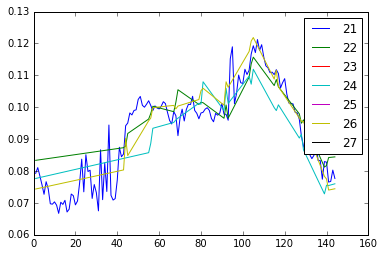

In [123]:
for i in range(21, 28):
    traffic1 = traffic_df[traffic_df.Date == '2016-01-%02d' % i]
    plt.plot(traffic1.groupby('TimePiece').traffic.mean(), label='%02d' % i)

plt.legend()

In [9]:
print len(sd_df)
sd_df[:3]

163491


,id,Date,TimePiece,demand,supply,gap,week
0,1,2016-01-01,1,187,178,9,4
1,1,2016-01-01,2,198,191,7,4
2,1,2016-01-01,3,192,182,10,4


In [11]:
sdgt_df = sd_df.merge(all_traffic, on=['id', 'Date', 'TimePiece'], how='left')
sdgt_df.describe()

,id,TimePiece,demand,supply,gap,week,traffic
count,163491.000000,163491.000000,163491.000000,163491.000000,163491.000000,163491.000000,158255.000000
mean,31.732909,78.289814,52.239047,42.963552,9.275495,3.011780,0.100479
std,18.562100,39.426369,112.348401,81.039485,49.817422,1.999978,0.038391
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,49.000000,4.000000,3.000000,0.000000,1.000000,0.073988
50%,31.000000,80.000000,12.000000,10.000000,1.000000,3.000000,0.098335
75%,47.000000,112.000000,47.000000,41.000000,4.000000,5.000000,0.125205
max,66.000000,144.000000,4362.000000,1084.000000,3872.000000,6.000000,0.666667


In [12]:
len(sdgt_df)

163491

In [ ]:
sd

In [25]:
print len(sdgt_df[sdgt_df.TimePiece == 2].traffic)
print len(sdgt_df[sdgt_df.TimePiece == 144].traffic)

1057
1096


In [15]:
traffic0 = (sdgt_df[sdgt_df.TimePiece == 2].traffic + sdgt_df[sdgt_df.TimePiece == 144].traffic) / 2

In [ ]:
sdgt_df[sdgt_df.TimePiece == 1].traffic.fillna()

In [ ]:
sdgt_df[sdgt_df.traffic.isnull()]